In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob


import gzip

from datetime import datetime



In [2]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=

# Unterschiedliche Verkehrszeichen in Deutschland für Radinfrastruktur



# --- 1) Schilder-Definitionen  --------------------------------
de_237     = "regulatory--bicycles-only--g1"                         # Radweg                        https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
de_240     = "regulatory--shared-path-pedestrians-and-bicycles--g1"  # Gemeinsamer Geh- und Radweg   https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
de_241_30  = "regulatory--dual-path-bicycles-and-pedestrians--g1"    # Getrennter Rad- und Gehweg    https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
de_241_31  = "regulatory--dual-path-pedestrians-and-bicycles--g1"    # Getrennter Rad- und Gehweg    https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
de_244_2   = "regulatory--end-of-bicycles-only--g2"                  # Ende Fahrradstraße            https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:244.2
de_1022_10 = "complementary--except-bicycles--g1"                    # Radfahrer frei                https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10
de_1000_33 = "complementary--bike-route--g1"                         # Radverkehr im Gegenverkehr    https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1000-33


# --- 2) Load Mapillary traffic sign data from parquet files  --------------------------------
# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/mapillary_traffic-signs_*.parquet")
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)


# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)


# --- 3) Filter for relevant traffic signs  --------------------------------
# filter for relevant traffic signs
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31, de_244_2, de_1022_10, de_1000_33])]

# cleanup
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=["tile_x", "tile_y"])


mapillary_trafficsigns_cw




Dates found in filenames: ['latest']


,geometry,first_seen_at,id,last_seen_at,value
15,POINT (8.5264 53.19977),2025-06-22,1340245383708340,2025-06-22,complementary--except-bicycles--g1
69,POINT (8.5467 53.19521),2025-05-31,1249414353590964,2025-05-31,regulatory--dual-path-pedestrians-and-bicycles...
111,POINT (8.57709 53.20527),2025-04-17,685464181098894,2025-11-13,regulatory--bicycles-only--g1
134,POINT (8.57521 53.20253),2025-04-17,1419980579009949,2025-09-18,complementary--bike-route--g1
186,POINT (8.57706 53.20525),2025-04-01,934699198683283,2025-08-30,regulatory--bicycles-only--g1
...,...,...,...,...,...
6612482,POINT (13.73586 52.42982),2020-06-14,2900354076872588,2020-06-14,regulatory--bicycles-only--g1
6612491,POINT (13.75473 52.43668),2019-06-30,4698444146838475,2019-06-30,regulatory--shared-path-pedestrians-and-bicycl...
6612495,POINT (13.75332 52.43291),2019-06-30,304750441127213,2019-06-30,regulatory--shared-path-pedestrians-and-bicycl...
6612502,POINT (13.75239 52.42995),2019-06-30,201521708547610,2019-06-30,regulatory--shared-path-pedestrians-and-bicycl...


In [3]:
import os
import json
# --- 2b) Read dataset metadata (instead of parsing dates from filenames) ---
metadata_path = os.path.join("..", "..", "output", "ml-ts_metadata.json")
ml_mf_metadata = None
ml_data_from = None
processed_date = None
bundeslaender_meta = {}

if os.path.exists(metadata_path):
    with open(metadata_path, "r", encoding="utf-8") as f:
        ml_mf_metadata = json.load(f)
    ml_data_from = ml_mf_metadata.get("ml_data_from")
    processed_date = ml_mf_metadata.get("processed_date")
    bundeslaender_meta = ml_mf_metadata.get("bundeslaender", {})
    print("✅ Loaded metadata:", metadata_path)
    print("  ml_data_from:", ml_data_from)
    print("  processed_date:", processed_date)
    print("  bundeslaender:", len(bundeslaender_meta))
else:
    print("⚠️ Metadata not found:", metadata_path)

# Keep a `dates` variable for backwards compatibility with later cells
dates = [d for d in [ml_data_from, processed_date] if d]

✅ Loaded metadata: ../../output/ml-ts_metadata.json
  ml_data_from: 2026-02-10T01:26:18.965524+00:00
  processed_date: 2026-02-10T05:40:21.568068+00:00
  bundeslaender: 16


## Verarbeitung fuer export fuer radinfra.de

In [4]:
### zeitlicher Filter: only signs seen after 2023-01-01

mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2023-01-01"].copy()
len(mapillary_trafficsigns_cw)

128558

In [5]:
### räumlicher Filter (Alle Traffic sign an Autobahnen raus, wg vielen falsch-positiven dort)

In [6]:
## parse autobahnen
# set_date = "251115" 
# motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")
# just use this static file, no need to process new motorways every time
motorways=gpd.read_parquet(f"../utils/processed_motorways_germany_251215.parquet")


## now create a buffer around the traffic signs to check if there is a cycleway nearby
mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw.to_crs(25833).copy()
mapillary_trafficsigns_cw_buffered_30["geometry"] = mapillary_trafficsigns_cw_buffered_30.geometry.buffer(30)
mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw_buffered_30.to_crs(mapillary_trafficsigns_cw.crs)


In [7]:
# helper 
def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [8]:
# For motorways (just 30m for both)
mapillary_trafficsigns_cw_buffered_30_mw = mark_intersections(mapillary_trafficsigns_cw_buffered_30, motorways, column_name="has_mw_intersection")

mapillary_trafficsigns_cw_30_mw_false=mapillary_trafficsigns_cw_buffered_30_mw[(mapillary_trafficsigns_cw_buffered_30_mw.has_mw_intersection== False)].copy()

# keep only entries in mapillary_trafficsigns_cw that are present in mapillary_trafficsigns_cw_30_mw_false
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["id"].isin(mapillary_trafficsigns_cw_30_mw_false["id"])].copy()
len(mapillary_trafficsigns_cw)

127378

In [9]:
# ### calculate days between first_seen_at and last_seen_at
def calc_days_between(row):
    try:
        d1 = datetime.strptime(row['first_seen_at'], "%Y-%m-%d")
        d2 = datetime.strptime(row['last_seen_at'], "%Y-%m-%d")
        return (d2 - d1).days
    except Exception:
        return None

mapillary_trafficsigns_cw["delta_days_seen"] = mapillary_trafficsigns_cw.apply(calc_days_between, axis=1)

In [10]:
# Hinweise ergänzen

mapillary_trafficsigns_cw["Hinweis"] = mapillary_trafficsigns_cw["delta_days_seen"].apply(
    lambda x: "Nur einmalig detektiert, ggf. temporär wie z.B. Baustelle." if x == 0 else ""
)
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw.drop(columns=["delta_days_seen"])

In [11]:
# Ergänzenden Hinweistext nur für value == de_1000_33 anhängen
hint_extra = (
    "Das Zusatzzeichen 1000-33 zeigt an, dass mit Radverkehr aus beiden Richtungen zu rechnen ist. "
    "Es wird häufig genutzt, um Einbahnstraßen für Radfahrer im Gegenverkehr freizugeben oder auf kreuzenden Radverkehr hinzuweisen. "
    "In radinfra.de ist die Darstellung des jeweiligen Einsatzkontexts aktuell noch eingeschränkt."
)

# Spalte sicherstellen
if "Hinweis" not in mapillary_trafficsigns_cw.columns:
    mapillary_trafficsigns_cw["Hinweis"] = ""

# Maske für bereits vorhandene (nicht-leere) Hinweise
existing_mask = mapillary_trafficsigns_cw["Hinweis"].notna() & (mapillary_trafficsigns_cw["Hinweis"].str.strip() != "")

# Maske für Zielwert (complementary--bike-route--g1)
target_mask = mapillary_trafficsigns_cw["value"].eq(de_1000_33)

# Anhängen bzw. setzen nur für Zielwert
mapillary_trafficsigns_cw.loc[target_mask & existing_mask, "Hinweis"] = (
    mapillary_trafficsigns_cw.loc[target_mask & existing_mask, "Hinweis"] + "\n" + hint_extra
)
mapillary_trafficsigns_cw.loc[target_mask & ~existing_mask, "Hinweis"] = hint_extra

In [12]:
#mapillary_trafficsigns_cw[mapillary_trafficsigns_cw.value == "complementary--bike-route--g1"].Hinweis[2213]

In [13]:
# Mapping dictionary
value_to_ts = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': "DE:241",
    'regulatory--dual-path-bicycles-and-pedestrians--g1': "DE:241",
    'regulatory--bicycles-only--g1': "DE:237",
    'regulatory--shared-path-pedestrians-and-bicycles--g1': "DE:240",

    'regulatory--end-of-bicycles-only--g2': "DE:244.2", 
    
    'complementary--except-bicycles--g1': "DE:1022-10",
    'complementary--bike-route--g1': "DE:1000-33"
}

value_to_tsd = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 'Getrennter Geh- und Radweg',
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 'Getrennter Geh- und Radweg',
    'regulatory--bicycles-only--g1': 'Radweg',
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 'Gemeinsamer Geh- und Radweg',

    'regulatory--end-of-bicycles-only--g2': 'Ende Fahrradstraße',

    'complementary--except-bicycles--g1': 'Radfahrer frei',
    'complementary--bike-route--g1': 'Radverkehr im Gegenverkehr'
}

# Add new column based on mapping
mapillary_trafficsigns_cw["traffic_sign"] = mapillary_trafficsigns_cw["value"].map(value_to_ts)
mapillary_trafficsigns_cw["traffic_sign_description"] = mapillary_trafficsigns_cw["value"].map(value_to_tsd)

In [14]:
mapillary_trafficsigns_cw

,geometry,first_seen_at,id,last_seen_at,value,Hinweis,traffic_sign,traffic_sign_description
15,POINT (8.5264 53.19977),2025-06-22,1340245383708340,2025-06-22,complementary--except-bicycles--g1,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:1022-10,Radfahrer frei
69,POINT (8.5467 53.19521),2025-05-31,1249414353590964,2025-05-31,regulatory--dual-path-pedestrians-and-bicycles...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:241,Getrennter Geh- und Radweg
111,POINT (8.57709 53.20527),2025-04-17,685464181098894,2025-11-13,regulatory--bicycles-only--g1,,DE:237,Radweg
134,POINT (8.57521 53.20253),2025-04-17,1419980579009949,2025-09-18,complementary--bike-route--g1,"Das Zusatzzeichen 1000-33 zeigt an, dass mit R...",DE:1000-33,Radverkehr im Gegenverkehr
186,POINT (8.57706 53.20525),2025-04-01,934699198683283,2025-08-30,regulatory--bicycles-only--g1,,DE:237,Radweg
...,...,...,...,...,...,...,...,...
6612406,POINT (13.73533 52.42971),2024-03-13,318392344194348,2024-03-13,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
6612419,POINT (13.75326 52.43272),2023-09-02,325542473257867,2023-09-02,regulatory--shared-path-pedestrians-and-bicycl...,"Nur einmalig detektiert, ggf. temporär wie z.B...",DE:240,Gemeinsamer Geh- und Radweg
6612422,POINT (13.75266 52.43104),2019-06-30,201843191848795,2023-09-02,regulatory--shared-path-pedestrians-and-bicycl...,,DE:240,Gemeinsamer Geh- und Radweg
6612444,POINT (13.75341 52.43277),2019-06-30,304773081124949,2023-05-01,regulatory--dual-path-bicycles-and-pedestrians...,,DE:241,Getrennter Geh- und Radweg


In [15]:
mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[['traffic_sign', 'traffic_sign_description', 'Hinweis',
    'first_seen_at', 'last_seen_at', 'id','value','geometry']]

## save to compressed geojson

In [16]:
# Save cw traffic sings to compressed GeoJSON and update readme

with gzip.open("ts_output/mapillary_trafficsigns_bicycle_latest.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(mapillary_trafficsigns_cw.to_json())

#     # Get the current date
#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # Create the content for the README file
#     readme_content = f"""
# # Traffic Signs Output
# This folder contains the output files for mapillary detected traffic signs.  
# The output has been created on {current_date}.

# Filter:
# - newer than 2023-01-01
# - signs for cycleways (DE:237, DE:240, DE:241)
# - signs for bicycle (DE:1022-10, DE:1000-33)
#     """

#     # Write the README file
#     with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
#         readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

### plot

In [17]:
import seaborn as sns

# 1) Seaborn-Theme (heller Hintergrund, feine Grids)
sns.set_theme(style="whitegrid", context="notebook",
              rc={
                  "axes.facecolor": "#e4e4ed",
                  "figure.facecolor": "#DADADF",
                  "grid.linestyle": ":",
                  "grid.alpha": 0.7,
              })



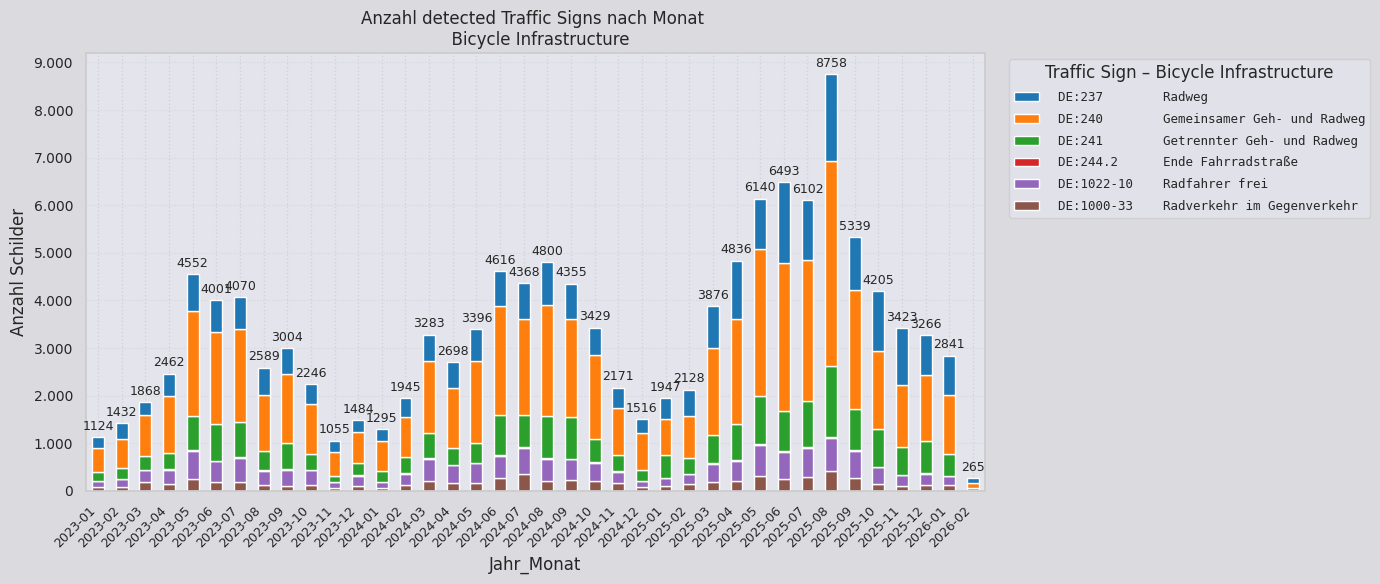

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

df = mapillary_trafficsigns_cw.copy()
df["month"] = pd.to_datetime(df["last_seen_at"]).dt.to_period("M").dt.to_timestamp()

# Pivot
pivot = (df.groupby(["month", "traffic_sign_description"])
           .size()
           .unstack(fill_value=0)
           .sort_index())

# Lückenlose Monatsachse
all_months = pd.date_range(pivot.index.min(), pivot.index.max(), freq="MS")
pivot = pivot.reindex(all_months, fill_value=0)
pivot.index.name = "month"

# === gewünschte Reihenfolge ===
order_top_to_bottom = [
    ("DE:237", "Radweg"),
    ("DE:240", "Gemeinsamer Geh- und Radweg"),
    ("DE:241", "Getrennter Geh- und Radweg"),
    ("DE:244.2", "Ende Fahrradstraße"),
    ("DE:1022-10", "Radfahrer frei"),
    ("DE:1000-33", "Radverkehr im Gegenverkehr"),
]


# # 2) Palette: Tab10 so mappen, dass "Radweg" die erste Farbe ist
# palette = sns.color_palette("tab10", n_colors=len(descs_top_to_bottom))
# # wir plotten bottom->top; daher Farben invertieren, damit Radweg (oben) trotzdem Farbe #0 bekommt
# colors_bottom_to_top = list(palette)[::-1]


descs_top_to_bottom = [desc for _, desc in order_top_to_bottom if desc in pivot.columns]
pivot_ordered = pivot[descs_top_to_bottom]

# === Farben: Tab10 starten bei "Radweg" ===
tab10 = plt.get_cmap("tab10")
colors = [tab10(i) for i in range(len(descs_top_to_bottom))]

# Reihenfolge fürs Plotten (bottom → top)
descs_bottom_to_top = descs_top_to_bottom[::-1]
colors_bottom_to_top = colors[::-1]

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
pivot_ordered[descs_bottom_to_top].plot(kind="bar", stacked=True, ax=ax, color=colors_bottom_to_top)

# Legende exakt in gewünschter Reihenfolge
handles_drawn, labels_drawn = ax.get_legend_handles_labels()
handle_by_label = dict(zip(labels_drawn, handles_drawn))

max_code_len = max(len(code) for code, desc in order_top_to_bottom)
legend_labels = [
    f"{code.ljust(max_code_len)}    {desc}".replace(" ", "\u00A0")
    for code, desc in order_top_to_bottom
    if desc in pivot_ordered.columns
]
legend_handles = [
    handle_by_label[desc]
    for _, desc in order_top_to_bottom
    if desc in pivot_ordered.columns
]


ax.legend(
    legend_handles, legend_labels,
    title="Traffic Sign – Bicycle Infrastructure",
    bbox_to_anchor=(1.02, 1), loc="upper left",
    prop={"family": "monospace", "size": 9},
    handletextpad=1.5, labelspacing=0.7
)


# Achsen & Layout
ax.set_xticks(range(len(pivot_ordered.index)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in pivot_ordered.index], rotation=45, ha="right")
ax.tick_params(axis="x", labelsize=9)

# keine wissenschaftliche Notation
ax.ticklabel_format(style='plain', axis='y')
# Tausenderpunkt (deutsches Schema)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.tick_params(axis="y", labelsize=10)


ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Jahr_Monat")
ax.set_ylabel("Anzahl Schilder")
ax.set_title("Anzahl detected Traffic Signs nach Monat \n  Bicycle Infrastructure")

# Totals über Balken
totals = pivot_ordered.sum(axis=1).to_numpy()
for i, total in enumerate(totals):
    if total > 0:
        ax.text(i, total + max(totals)*0.01, str(int(total)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("ts_output/signs_by_month.svg", bbox_inches="tight")
plt.show()


In [19]:
# quick check
print("ml_data_from:", ml_data_from)
print("processed_date:", processed_date)
print("bundeslaender (count):", len(bundeslaender_meta) if isinstance(bundeslaender_meta, dict) else None)

ml_data_from: 2026-02-10T01:26:18.965524+00:00
processed_date: 2026-02-10T05:40:21.568068+00:00
bundeslaender (count): 16


### create readme file

In [20]:
from datetime import datetime
import pandas as pd

# === deine DataFrame-Basis ===
# mapillary_trafficsigns_cw = ...

# Zähle die Anzahl pro Beschreibung
counts = mapillary_trafficsigns_cw["traffic_sign_description"].value_counts().to_dict()

# Hole das aktuelle Datum
#current_date = datetime.now().strftime("%Y-%m-%d")

# Hole das Dataset-Datum aus den Parquet-Filenames (Fallback: heute)
if dates:
    try:
        parsed_dates = sorted(pd.to_datetime(dates))
        last_date = parsed_dates[-1].strftime("%Y-%m-%d")
    except Exception:
        last_date = datetime.now().strftime("%Y-%m-%d")
else:
    last_date = datetime.now().strftime("%Y-%m-%d")

# Mapping für Reihenfolge und Metadaten
sign_info = [
    ("DE:237", "regulatory--bicycles-only--g1", "Radweg", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_237.36e48b6d.svg"),
    ("DE:240", "regulatory--shared-path-pedestrians-and-bicycles--g1", "Gemeinsamer Geh- und Radweg", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_240.c2d222a0.svg"),
    ("DE:241", "regulatory--dual-path-pedestrians-and-bicycles--g1`<br>`regulatory--dual-path-bicycles-and-pedestrians--g1", "Getrennter Geh- und Radweg", 
        "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_241_31.3627eb18.svg",
        "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_241_30.7eec6f94.svg"),
    ("DE:244.2", "regulatory--end-of-bicycles-only--g2", "Ende Fahrradstraße", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_244_2.b586a5a6.svg"),
    ("DE:1022-10", "complementary--except-bicycles--g1", "Radfahrer frei", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_1022_10.cda7bd53.svg"),
    ("DE:1000-33", "complementary--bike-route--g1", "Radverkehr im Gegenverkehr", "https://trafficsigns.osm-verkehrswende.org/_next/static/media/DE_1000_33.c18820f3.svg"),
]

# === Markdown-Tabelle bauen ===
table_rows = []
for info in sign_info:
    code, wording, desc, *imgs = info
    count = counts.get(desc, 0)

    # Bild(e) zusammenbauen
    if len(imgs) == 2:
        img_md = f'<img src="{imgs[0]}" width="40"> oder <img src="{imgs[1]}" width="40">'
    else:
        img_md = f'<img src="{imgs[0]}" width="40">'

    # Reihenfolge angepasst an: VZ-Code | Beschreibung | Verkehrszeichen | Anzahl | Mapillary Wording
    row = f"| {code} | {desc} | {img_md} | {count} | `{wording}` |"
    table_rows.append(row)


table = "\n".join([
    "| VZ-Code | Beschreibung | Verkehrszeichen | Anzahl | Mapillary Wording |",
    "|-------|-------------|:---------------:|-------:|-----------------|",
    *table_rows
])

# === README-Text ===
readme_content = f"""
# Bicycle Infrastucture Traffic Signs Output

This folder contains the output file for detected traffic signs related to bicycle infrastructure from Mapillary.  
The output has been created on **{last_date}**.

## Applied Filters

- Only detections newer than **2023-01-01**
- Excluded all signs located within **30 m of motorways** (to reduce false positives)

## Signs

{table}

## Statistics Plot

![Anzahl pro Monat](signs_by_month.svg)
"""

# === Datei schreiben ===
with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
    readme_file.write(readme_content)

print("✅ README.md erfolgreich erstellt!")


✅ README.md erfolgreich erstellt!
